In [1]:
import pandas as pd
import numpy as np
# %matplotlib notebook 
    ## to enable interactive graphics
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML

import csv

# %matplotlib notebook
# plt.interactive(False)

In [28]:
filename = 'result_30.csv'
#df = pd.read_csv(filename)
# convert dataframe
photon_dict = {} # key: photon id, value: list(tuple(x,y,z,E,obj_id))
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader)
    for row in reader:
        pid = int(row[0])
        tup = (float(row[1]), float(row[2]), float(row[3]), float(row[4]), int(row[5]))
        if pid in photon_dict:
            photon_dict[pid].append(tup) # events are output in chronological order, so this works
        else:
            photon_dict[pid] = [tup]


# Event Plotting
Functions for plotting the positions where events occur.

In [3]:
def imageScatter(df, elev = 30, azith = 30):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ='3d')

    plot = ax.scatter3D(df.x, df.y, df.z, c=df.E, cmap='Blues')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


    plt.colorbar(plot, ax=ax)

    #elev = 60 # elevation angle in z plane
    # azith = 120 # azimuth angle in xy plane
    ax.view_init(elev, azith)

    plt.show()

In [4]:
def videoScatter(df):
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111, projection ='3d')

    plot, = ax.plot(df.x, df.y, df.z, 'b.', alpha = 0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


    def init():
        return plot,

    def update(frame):
        ax.view_init(frame/8, frame)
        return plot,

    ani = FuncAnimation(fig, update, frames=np.linspace(0, 360, 360), init_func=init, blit=True, interval=33)
    HTML(ani.to_html5_video())

In [3]:
def plot_slice(photondict, lower, upper, axis1=0, axis2=2, axisslice=1, obj=set()):
    fig, ax = plt.subplots()
    ax.axis('equal')
    points_x = []
    points_y = []
    for events in photondict.values():
        for xyzei in events:
            if xyzei[4] in obj and xyzei[axisslice] < upper and xyzei[axisslice] > lower:
                points_x.append(xyzei[axis1])
                points_y.append(xyzei[axis2])
    ax.scatter(points_x, points_y)
    print("Matched events:", len(points_x))
    plt.show()
    return (points_x, points_y)

In [15]:
def heatmap(xs, ys, bins=50, gamma=0.5):
    fig, ax = plt.subplots()
    ax.axis('square')
    h = ax.hist2d(xs, ys, bins=bins, norm=mcolors.PowerNorm(gamma))
    fig.colorbar(h[3], ax=ax)
    plt.show()

In [4]:
def plot_paths(photondict, axis1=0, axis2=2, obj=set()):
    fig, ax = plt.subplots()
    ax.axis('equal')
    for events in photondict.values():
        objs = {xyzei[4] for xyzei in events}
        points_x = []
        points_y = []
        if obj.issubset(objs):
            for xyzei in events:
                points_x.append(xyzei[axis1])
                points_y.append(xyzei[axis2])
            ax.plot(points_x, points_y)
    plt.show()

# Path Analysis
For coincidence-gated simulation data only. For number of events along paths, and typical scattering angles represented for single-scatter events.

In [36]:
def get_n_interactions(events, obj=0):
    # given event tuples (x, y, z, energy, object index)
    # return number of tuples that have object index = obj
    ct = 0
    for xyzei in events:
        if xyzei[4] == obj:
            ct += 1
    return ct
    
def list_n_interactions(photondict, obj=0):
    interaction_numbers = []
    for photon_id in photondict:
        interaction_numbers.append(get_n_interactions(photondict[photon_id], obj))
    return interaction_numbers
    
def filter_single_interactions(photondict, obj=0):
    # returns a new dict where entries only interact once with object index obj. 
    # For coincidence-gated data, this means a single scatter.
    filtered = dict(photondict)
    for photon_id in photondict:
        # check for number of times interacted with obj
        events = photondict[photon_id]
        if get_n_interactions(events) != 1:
            del filtered[photon_id]
    return filtered

def list_single_angles(photondict, obj=0):
    # assuming single interactions in obj correspond to single scattering events,
    # calculate the scattering angle and return in a list.
    sspdict = filter_single_interactions(photondict, obj)
    angles = []
    for photon_id in sspdict:
        events = sspdict[photon_id]
        # get the index of the event
        sidx = 100000
        for idx, xyzei in enumerate(events):
            if xyzei[4] == obj:
                sidx = idx
                break;
        pre = events[sidx-1] # xyzei
        sca = events[sidx]
        nex = events[sidx+1]
        v1 = np.array((sca[0]-pre[0], sca[1]-pre[1], sca[2]-pre[2]))
        v2 = np.array((nex[0]-sca[0], nex[1]-sca[1], nex[2]-sca[2]))
        n1 = v1 / np.linalg.norm(v1)
        n2 = v2 / np.linalg.norm(v2)
        d = n1.dot(n2)
        angles.append(np.arccos(d))
    return angles
        

# Spectra Simulation
For coincidence-gated simulation data only. Per-photon analysis of energy deposited in each object. Simulated energy spectra.

# Playground

## Looking at some plots

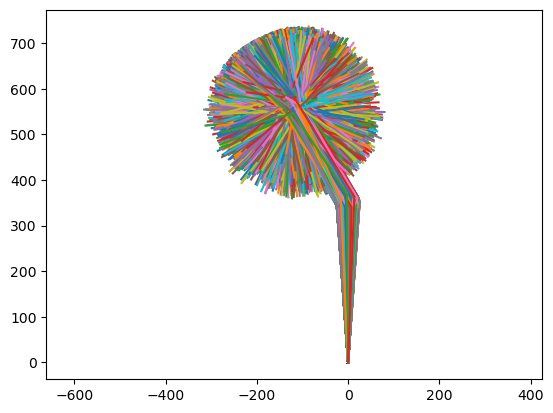

In [29]:
plot_paths(photon_dict, obj={0,1})

Matched events: 64004


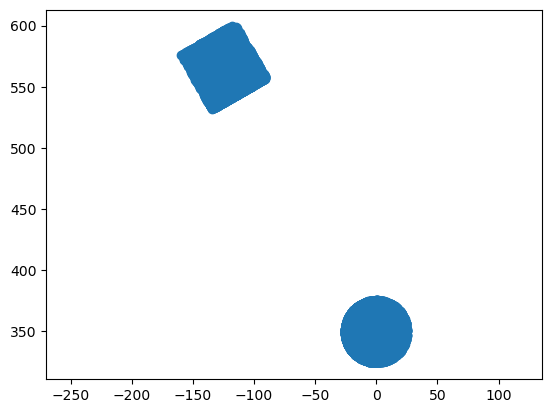

In [51]:
xs, ys = plot_slice(photon_dict, -100, 100, obj=[0,1])

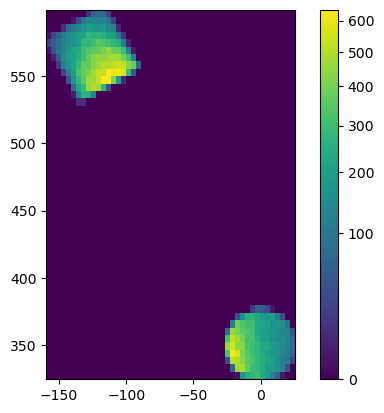

In [52]:
heatmap(xs, ys, bins=50)

## Seeing what the most representative angle is

In [40]:
n_inter = list_n_interactions(photon_dict, 0)
print("Average number of interactions with recoil detector per photon:", np.mean(n_inter))

Typical number of interactions with recoil detector per photon: 1.8085275423728813


Total photons coincident: 15104
Number of photons with one scattering event in recoil detector: 7294
Matched events: 25220


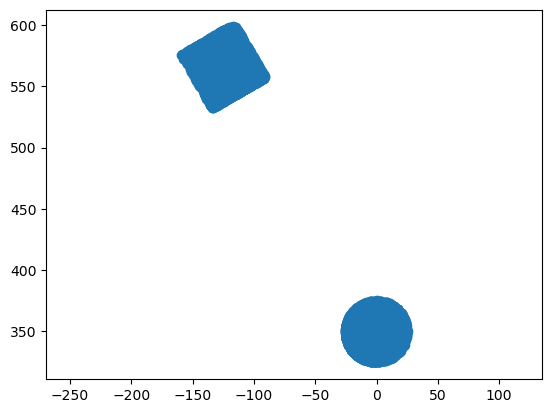

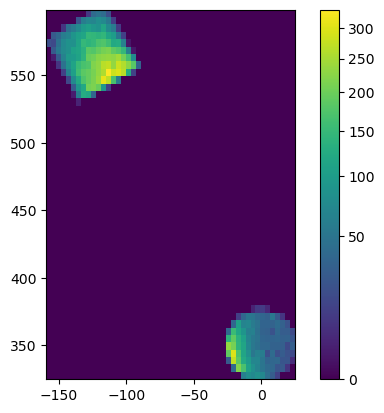

In [50]:
singles = filter_single_interactions(photon_dict, 0)
print("Total photons coincident:", len(photon_dict))
print("Number of photons with one scattering event in recoil detector:", len(singles))
xss, yss = plot_slice(singles, -1000, 1000, obj=[0,1])
heatmap(xss, yss)

In general, it seems for the photons with a longer path through the recoil detector, they do tend to scatter more than once. This means the "representative" angle calculated this way will have a systematic bias, since we don't know how to account for those photons which scatter more than once.

Mean angle (deg): 26.545242644585638


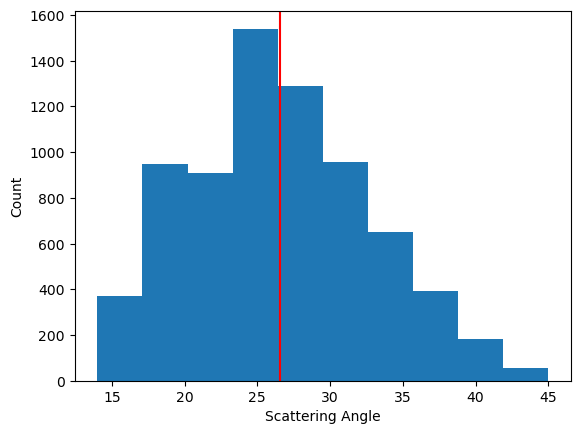

In [59]:
angles = np.array(list_single_angles(photon_dict, 0)) * 180 / np.pi
print("Mean angle (deg):", np.mean(angles))
plt.hist(angles, bins=10)
plt.axvline(np.mean(angles), color='red')
plt.xlabel("Scattering Angle")
plt.ylabel("Count")
plt.show()

To more accurately correct our data, accounting for second-order scattering and higher, we'll probably be best served looking at the resulting spectra.

## Trying to get the expected spectrum